# Домашнее задание №3
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Проверка ряда на стационарность](#checkup)
* [Удаление тренда](#trendremove)
* [Удаление сезонности](#seasonremove)
* [Автокорреляция](#acf)
* [Частичная автокорреляция](#pacf)
* [AR модель](#ar)
* [Оценка метрик](#benchmark)


### Проверка ряда на стационарность <a id="checkup"></a>

In [112]:
import os
import pandas as pd
import numpy as np

from os import path
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [113]:
load_dotenv(dotenv_path='../.env')

True

Импортируем данные

In [114]:
file_path = os.getenv('PATH_TO_DATA')

sales_df = pd.read_csv(path.join(os.sep, file_path, 'data.csv'))

Функция, которая добавляет легенду на график

In [115]:
def plot_assignation(axp, data, xlabel, ylabel, title1, periods):
    axp.plot(data)
    axp.set_xlabel(xlabel)
    axp.set_ylabel(ylabel)
    axp.set_title(title1)
    axp.set_xticks(np.arange(0, len(sales_df['x']) + 1, 12))
    axp.set_xticklabels(np.arange(periods + 1))

Функция, которая проверяет ряд на стационарность

In [116]:
from statsmodels.tsa.stattools import adfuller

def adfooler_test(dataframe: pd.DataFrame, alpha: float):
    dftest = adfuller(dataframe, autolag='AIC')
    output_dict = pd.Series(dftest[0:4], index=[
        'Test Statistic',
        'p-value',
        '#Lags used',
        '#Observation used'
    ])

    for key, value in dftest[4].items():
        output_dict['Critical Value (%s)'%key] = value
    print(output_dict)

    if output_dict['p-value'] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше равно {alpha * 100}%. Ряд не стационарный.")

В соответсвтии с моими данными я визуализирую выборку на графике и добавляю его легенду

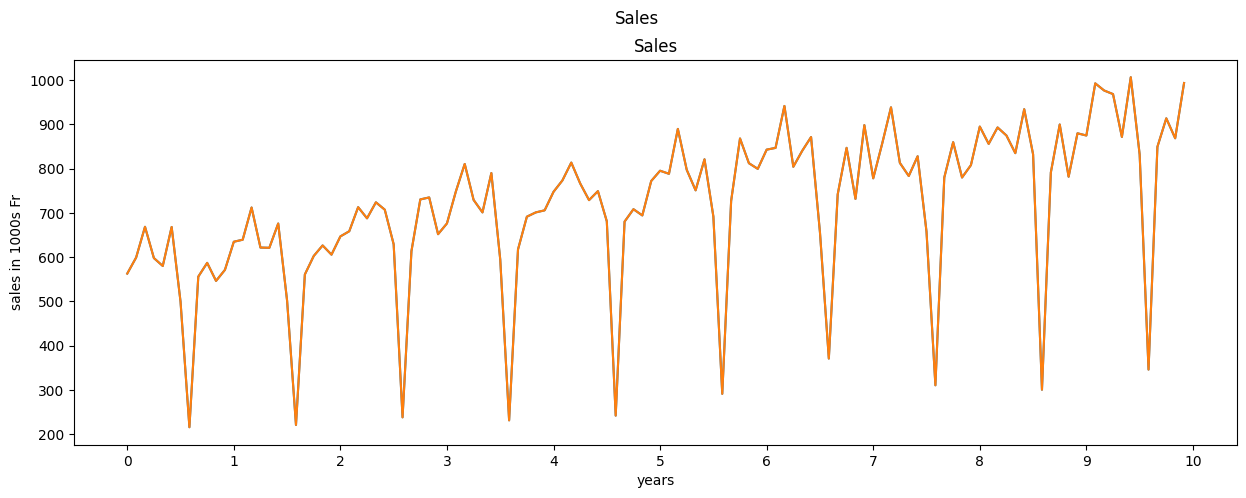

In [117]:
#выборка по 10 годам
period = 10

fig, axs = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Sales')
plot_assignation(axs, sales_df["x"], "years","sales in 1000s Fr","Sales", period)
axs.plot(sales_df['x'])

Проверим ряд на стационарность

In [118]:
adfooler_test(dataframe=sales_df['x'], alpha=0.05)

Test Statistic           -0.167042
p-value                   0.942338
#Lags used               11.000000
#Observation used       108.000000
Critical Value (1%)      -3.492401
Critical Value (5%)      -2.888697
Critical Value (10%)     -2.581255
dtype: float64
Значение p больше равно 5.0%. Ряд не стационарный.


### Удаление тренда <a id="trendremove"></a>

Для нахождения тренда применим к ряду разложение на компоненты.
Продфифференцируем удалим тренд по формуле дифференцирования:

$y'=y_{t} -y_{t-1}$

In [119]:
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Optional

#returns copy of dataframe without trend component
def remove_trend(dataframe: pd.DataFrame, period: Optional[int] = None) -> pd.DataFrame:
    if period is not None:
        decomposed = seasonal_decompose(dataframe, period=period)
    else:
        decomposed = seasonal_decompose(dataframe)
    
    dataframe_np = dataframe.to_numpy()
    dataframe_wt = []

    for i in range(1, len(dataframe_np)):
        dataframe_wt.append(dataframe_np[i] - dataframe_np[i - 1])
    
    return pd.DataFrame(dataframe_wt)

Получим ряд с без тренда и визуализируем его

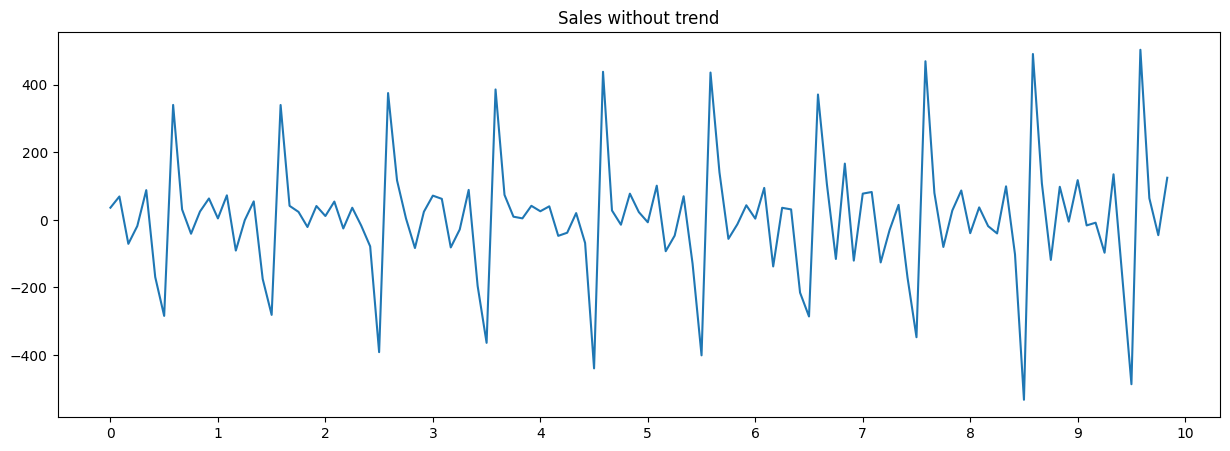

In [120]:
sales_df_without_trend = remove_trend(dataframe=sales_df['x'], period=10)

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(axs, sales_df_without_trend, "", "", "Sales without trend", 10)

Проверим ряд на стационарность

In [121]:
adfooler_test(dataframe=sales_df_without_trend,alpha=0.05)

Test Statistic           -3.751563
p-value                   0.003444
#Lags used               13.000000
#Observation used       105.000000
Critical Value (1%)      -3.494220
Critical Value (5%)      -2.889485
Critical Value (10%)     -2.581676
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Удаление сезонности <a id="seasonremove"></a>

Воспользуемся формулой удаления сезонности
$y'=y_{t} -y_{t-s}$
В моем случае ряд состоит из 120 записей за 10 лет, т.е. 1 запись раз в месяц. Отсюда я сделал вывод, что в моем случае $s = 12$

Сделал я его на основе этой [статьи](https://machinelearningmastery.com/time-series-seasonality-with-python/)

In [122]:
#returns copy of dataframe without trend component
def remove_seasonal(dataframe: pd.DataFrame, season: int, period: Optional[int] = None) -> pd.DataFrame:
    if period is not None:
        decomposed = seasonal_decompose(dataframe, period=period)
    else:
        decomposed = seasonal_decompose(dataframe)
    
    dataframe_np = dataframe.to_numpy()
    dataframe_ws = []

    for i in range(season, len(dataframe_np)):
        dataframe_ws.append(dataframe_np[i] - dataframe_np[i - season])
    
    return pd.DataFrame(dataframe_ws)

Получим ряд с без сезонной компоненты и визуализируем его

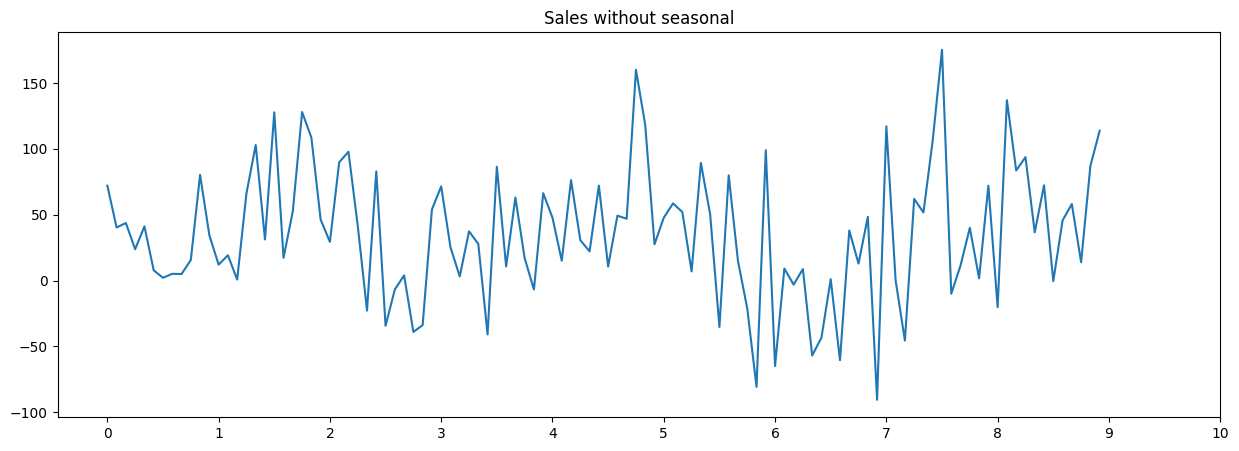

In [123]:
sales_df_without_seasonal = remove_seasonal(dataframe=sales_df['x'], period=10, season=12)

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(axs, sales_df_without_seasonal, "", "", "Sales without seasonal", 10)

Проверим ряд на стационарность

In [124]:
adfooler_test(dataframe=sales_df_without_seasonal,alpha=0.05)

Test Statistic          -3.480630
p-value                  0.008499
#Lags used              11.000000
#Observation used       96.000000
Critical Value (1%)     -3.500379
Critical Value (5%)     -2.892152
Critical Value (10%)    -2.583100
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Автокорреляция <a id="acf"></a>

Я взял lag=30, руководствуясь этой [статьей](https://wiki.loginom.ru/articles/autocorrelation.html)

Цитата: *... обычно рекомендуют максимальный порядок коэффициента автокорреляции, равный $n / 4$
.*

В моем случае $n = 120$, значит берем lag=30

Посмотрим на автокорреляцию

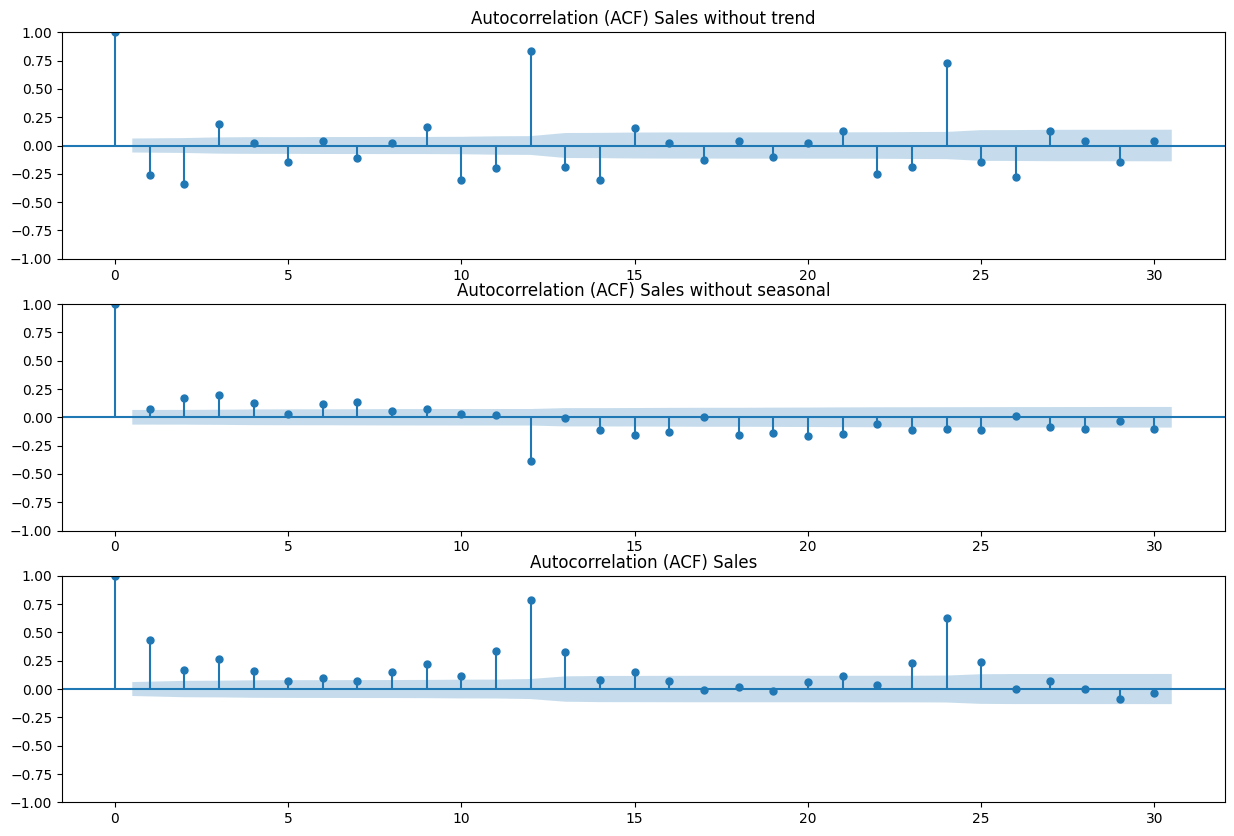

In [125]:
import statsmodels.tsa.api as smt

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

smt.graphics.plot_acf(sales_df_without_trend, lags=30, alpha=0.5, ax=axs[0])
smt.graphics.plot_acf(sales_df_without_seasonal, lags=30, alpha=0.5, ax=axs[1])
smt.graphics.plot_acf(sales_df['x'], lags=30, alpha=0.5, ax=axs[2])

axs[0].set_title('Autocorrelation (ACF) Sales without trend')
axs[1].set_title('Autocorrelation (ACF) Sales without seasonal')
axs[2].set_title('Autocorrelation (ACF) Sales')

plt.show()

### Частичная автокорреляция <a id="pacf"></a>

Посмотрим на частичную автокорреляцию

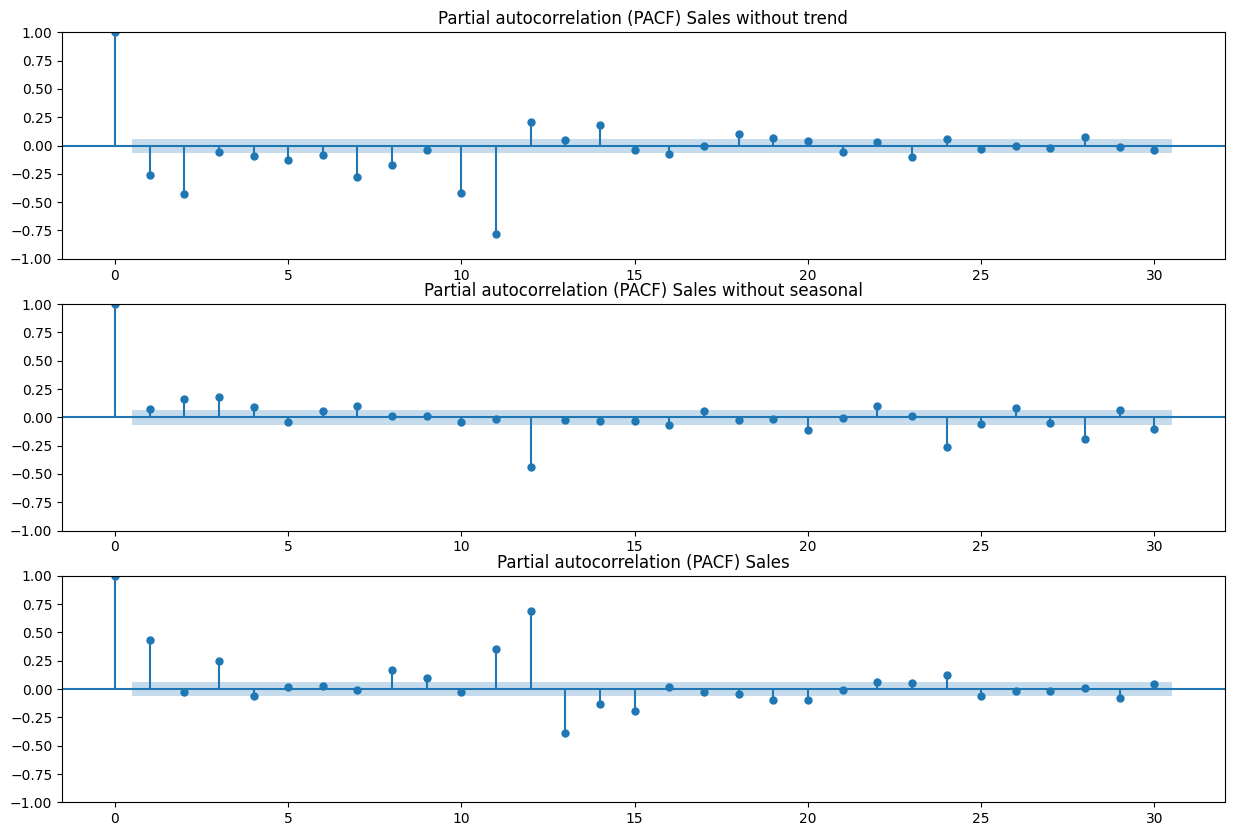

In [126]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

smt.graphics.plot_pacf(sales_df_without_trend, lags=30, alpha=0.5, ax=axs[0])
smt.graphics.plot_pacf(sales_df_without_seasonal, lags=30, alpha=0.5, ax=axs[1])
smt.graphics.plot_pacf(sales_df['x'], lags=30, alpha=0.5, ax=axs[2])

axs[0].set_title('Partial autocorrelation (PACF) Sales without trend')
axs[1].set_title('Partial autocorrelation (PACF) Sales without seasonal')
axs[2].set_title('Partial autocorrelation (PACF) Sales')

plt.show()